# Food Recognition model using PyTorch using Food101 dataset

* author: Amal Varghese
* email: officialamalv2004@gmail.com

In [15]:
import torch
from torch import nn
import torchvision
from torchvision import datasets

print("Using PyTorch version:", torch.__version__)
print("Using torchvision version:", torchvision.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Using PyTorch version: 2.7.0+cu118
Using torchvision version: 0.22.0+cu118
Device: cuda


# Getting the data ready
- using torchvision datasets
- apply a custom transform

In [16]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size = (224 , 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    # transforms.Normalize(                     # Normalize to ImageNet mean/std
    #     mean=[0.485, 0.456, 0.406],
    #     std=[0.229, 0.224, 0.225]
    # )
])

test_transform = transforms.Compose([
    transforms.Resize(size = (224 , 224)),
    transforms.ToTensor(),
    # transforms.Normalize(                     # Normalize to ImageNet mean/std
    #     mean=[0.485, 0.456, 0.406],
    #     std=[0.229, 0.224, 0.225]
    # )
])

print(f"Train transform: {train_transform}")
print(f"Test transform: {test_transform}")

Train transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ToTensor()
)
Test transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [17]:
train_data = datasets.Food101(
    root="data",
    split="train",
    download=False,
    transform=train_transform,
)

test_data = datasets.Food101(
    root="data",
    split="test",
    download=False,
    transform=test_transform
)

print(f"Length of train_dataset: {len(train_data)}")
print(f"length of test data: {len(test_data)}")

Length of train_dataset: 75750
length of test data: 25250


# Exploartory Data Analysis

In [ ]:
test_data_refined = torch.utils.data.Subset(test_data, range(0, 10000))
print(f"length of new test data: {len(test_data_refined)}")

length of new test data: 10000


In [19]:
image, label = train_data[0]
print(f"Image Shape: {image.shape} -> [color channels , height, width]")
classes = train_data.classes
print(f"Total number of classes:{len(classes)}")

Image Shape: torch.Size([3, 224, 224]) -> [color channels , height, width]
Total number of classes:101


In [20]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # Go up from notebooks/ to project root


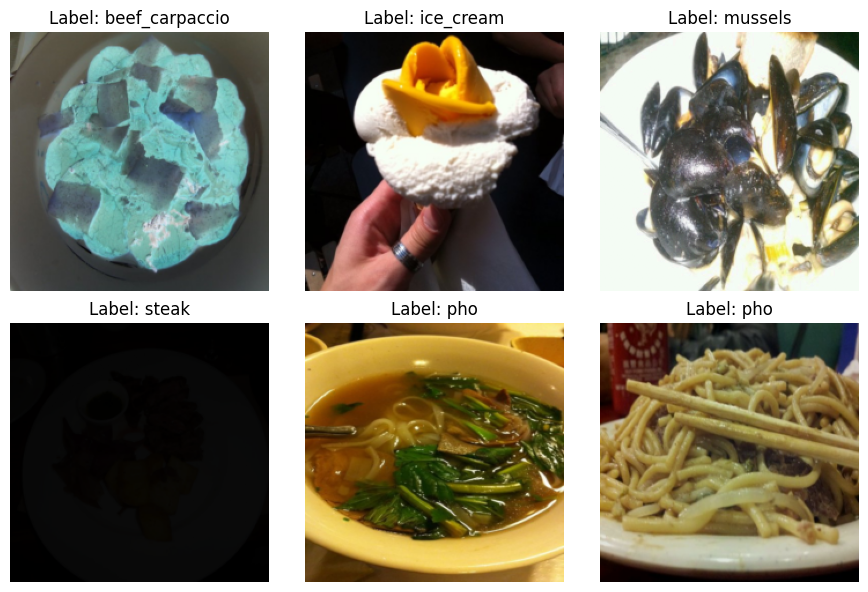

In [21]:
from helper.Visualize import plot_random_images
from helper.Visualize import plot_image

plot_random_images(train_data , num=6)

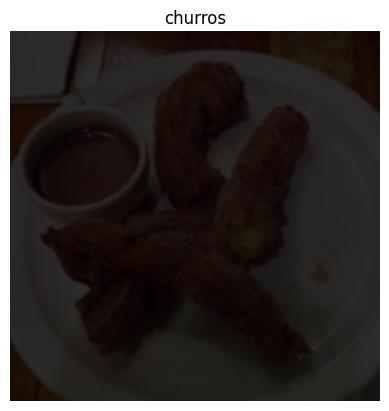

In [22]:
plot_image(train_data[0][0] , classes[train_data[0][1]])

# Creating Model

* starting with TinyVGG

In [23]:
class TinyVGG(nn.Module):
    def __init__(self , input_layer: int, hidden_layer:int, output_layer:int, dropout_rate: int = 0.25)->None:
        """
        A basic TinyVGG model to perform benchmark test for the model
        """
        super(TinyVGG, self).__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_layer, out_channels=hidden_layer, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(hidden_layer),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layer, out_channels=hidden_layer, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(hidden_layer),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(dropout_rate)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_layer, hidden_layer, 3, 1,1),
            nn.BatchNorm2d(hidden_layer),
            nn.ReLU(),

            nn.Conv2d(hidden_layer, hidden_layer, 3, 1, 1),
            nn.BatchNorm2d(hidden_layer),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_layer*56*56 , output_layer)
        )
    
    def forward(self, x):
        return self.classifier(self.block_2(self.block_1(x)))

create a model instance

In [24]:
model_0 = TinyVGG(3 , 100 , len(classes)).to(device)
model_0

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
  )
  (block_2): Sequential(
    (0): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [25]:
image, label = train_data[0]
# Add batch dimension
image = image.unsqueeze(0)
model_0(image.to(device))

tensor([[-8.3782e-01, -6.5892e-01, -1.3044e+00, -2.6676e-01,  6.0043e-01,
          7.7339e-01, -5.7266e-01,  1.8727e-01,  4.6970e-01,  6.7280e-02,
         -3.2484e-01,  9.6484e-01,  3.0164e-01, -8.2555e-01, -4.3018e-01,
         -7.6866e-01, -2.0655e-01,  1.5866e+00, -2.6718e-01, -1.0378e+00,
         -5.6938e-01, -7.3993e-01, -4.7638e-01, -2.9776e-01, -4.2170e-01,
         -1.6976e+00, -6.6772e-02, -7.3315e-01,  1.2553e+00, -5.1625e-02,
          4.5576e-01,  9.0438e-02,  3.5298e-01, -3.9648e-01,  4.1629e-01,
          1.2081e+00,  1.7447e-01, -6.2818e-01,  5.3352e-01, -2.7169e-01,
         -2.2714e-01, -1.5811e+00, -5.4613e-02,  4.3958e-01,  6.3624e-01,
          3.7174e-01,  1.9080e-02,  8.1623e-01,  4.7575e-01,  1.5655e+00,
         -1.0612e-01,  6.4303e-01,  6.6910e-01,  5.1754e-01,  5.4676e-01,
         -6.8990e-04, -3.6605e-01, -1.0788e+00,  3.2482e-01,  3.3613e-01,
          4.8504e-01, -7.2813e-01,  5.6226e-01, -9.7912e-01,  1.2683e+00,
         -2.3356e-01,  5.1797e-01, -1.

This means that the model is successfully taking image values in the batchified form, so now we need to batchify it in the dataloaded

In [31]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(train_dataloader)
print(test_dataloader)

In [27]:
# Reduce dataset size for faster experimentation
from torch.utils.data import Subset

SMALL_TRAIN_SIZE = 1000  # You can adjust this number
SMALL_TEST_SIZE = 500

small_train_data = Subset(train_data, range(SMALL_TRAIN_SIZE))
small_test_data = Subset(test_data, range(SMALL_TEST_SIZE))

small_train_dataloader = DataLoader(
    dataset=small_train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0  # Use 0 for Windows for stability
)

small_test_dataloader = DataLoader(
    dataset=small_test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"Reduced train set size: {len(small_train_data)}")
print(f"Reduced test set size: {len(small_test_data)}")

Reduced train set size: 1000
Reduced test set size: 500


In [33]:
image, label = next(iter(train_dataloader))
print(f"Shape of Image:{image.shape} -> [Batches, color channels, height, weight]")

Shape of Image:torch.Size([32, 3, 224, 224]) -> [Batches, color channels, height, weight]


In [36]:
from torchinfo import summary

summary(model_0 , 
        input_size=(32,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 101]                 --
├─Sequential: 1-1                        [32, 100, 112, 112]       --
│    └─Conv2d: 2-1                       [32, 100, 224, 224]       2,800
│    └─BatchNorm2d: 2-2                  [32, 100, 224, 224]       200
│    └─ReLU: 2-3                         [32, 100, 224, 224]       --
│    └─Conv2d: 2-4                       [32, 100, 224, 224]       90,100
│    └─BatchNorm2d: 2-5                  [32, 100, 224, 224]       200
│    └─ReLU: 2-6                         [32, 100, 224, 224]       --
│    └─MaxPool2d: 2-7                    [32, 100, 112, 112]       --
│    └─Dropout2d: 2-8                    [32, 100, 112, 112]       --
├─Sequential: 1-2                        [32, 100, 56, 56]         --
│    └─Conv2d: 2-9                       [32, 100, 112, 112]       90,100
│    └─BatchNorm2d: 2-10                 [32, 100, 112, 112]       200
│

In [ ]:
def train_step(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        device: torch.device
):
    #Set the model to training mode
    model.train()
    #set a variable to track train and test loss
    train_loss, train_acc = 0 , 0

    #training loop
    for batch, (X,y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        #Forward pass
        y_pred = model(X)
        #Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        #optimize
        optimizer.zero_grad()
        #Backpropogation
        loss.backward()
        #perform gradient descent
        optimizer.step()

        #Calculate the train accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    
    train_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)

    return train_loss, train_acc

In [38]:
def test_step(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        device: torch.device,
        scheduler=None
):
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # forward pass
            y_preds = model(X)
            # calculate the loss
            loss = loss_fn(y_preds, y)
            test_loss += loss.item()
            
            y_pred_class = torch.argmax(torch.softmax(y_preds, dim=1), dim=1)
            test_acc += (y_pred_class == y).sum().item() / len(y_pred_class)
        test_acc = test_acc / len(dataloader)
        test_loss = test_loss / len(dataloader)

        if scheduler is not None:
            scheduler.step(test_loss)
    
    return test_loss, test_acc
            